# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [2]:
import os
import re
import emoji
import pandas as pd
import numpy as np
import glob


from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

In [4]:
punctuation = set(punctuation)
tw_punct = punctuation - {"#"}

# Stopwords - added the 'nan' to this to remove nulls:

sw = stopwords.words("english")
sw = sw + ['nan']

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

#emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

#functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """

    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens/num_tokens
    num_characters = sum(len(token) for token in tokens)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])    


    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)

# Function to remove stop words:

def remove_stop(tokens) :


    return[t for t in tokens if t not in sw]
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    return([item.lower() for item in whitespace_pattern.split(text)])
    


pipeline = [str.lower, tokenize, remove_punctuation, remove_stop]

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

In [5]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/jackieurenda/Desktop/ADS 509/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [7]:
#read in lyrics data

artists = ["cher", "robyn"]
lyrics_files = []
artist_list = []
lyrics_list = []
song_list = []

for a in artists:
    artist_files = glob.glob(os.path.normpath(os.path.join(data_location + lyrics_folder + a, "*.txt")))
    list = [a] * len(artist_files)
    artist_list = artist_list + list
    lyrics_files = lyrics_files + artist_files


for file in lyrics_files:
    file = open(file, "r")
    title = file.readline().rstrip()
    song_list.append(title)

    
    list = file.readlines()[1:]
    lyrics = "".join(list)
    lyrics = lyrics.replace('\n', " ")
    lyrics_list.append(lyrics)


In [8]:
# Convert to df
dict = {'artist': artist_list, 'song': song_list, 'lyrics': lyrics_list}
lyrics_data = pd.DataFrame(dict)

lyrics_data.head()

,artist,song,lyrics
0,cher,"""Come And Stay With Me""",I'll send away all my false pride And I'll f...
1,cher,"""Pirate""",He'll sail on with the summer wind That blow...
2,cher,"""Stars""",I was never one for saying what I really fee...
3,cher,"""These Days""",Well I've been out walking And I don't do t...
4,cher,"""Love So High""",Every morning I would wake up And I'd tie th...


In [10]:
#read in twitter data

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}

twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

twitter_data.head()


,screen_name,name,id,location,followers_count,friends_count,description,artist
0,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN,cher
1,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher
2,anju79990584,anju,1496463006451974150,NaN,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher
3,gallionjenna,J,3366479914,NaN,752,556,csu,cher
4,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...,cher


In [ ]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

In [11]:
#reading in the tidytext file:

tidy_text = pd.read_csv('tidytext_sentiments.txt', sep='\t')

tidy_text.head()

,word,sentiment,lexicon
0,abandon,negative,nrc
1,abandoned,negative,nrc
2,abandonment,negative,nrc
3,abba,positive,nrc
4,abduction,negative,nrc


In [13]:
tidy_text['sentiment_score'] = tidy_text['sentiment'].replace({'negative' : -1, 'positive' : 1})

tidy_text.head(10)

,word,sentiment,lexicon,sentiment_score
0,abandon,negative,nrc,-1
1,abandoned,negative,nrc,-1
2,abandonment,negative,nrc,-1
3,abba,positive,nrc,1
4,abduction,negative,nrc,-1
5,aberrant,negative,nrc,-1
6,aberration,negative,nrc,-1
7,abhor,negative,nrc,-1
8,abhorrent,negative,nrc,-1
9,ability,positive,nrc,1


<AxesSubplot: >

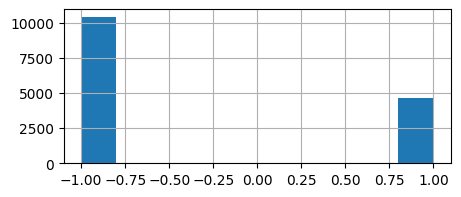

In [14]:
tidy_text['sentiment_score'].hist(figsize=(5,2))

### Bing Liu Lexicon

In [15]:
import nltk
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize
nltk.download('opinion_lexicon')

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/jackieurenda/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


True

In [16]:
pos_score = 1
neg_score = -1
word_dict = {}

for word in opinion_lexicon.positive():
    word_dict[word] = pos_score

for word in opinion_lexicon.negative():
    word_dict[word] = neg_score

def bing_liu_score(text):
    sentiment_score = 0
    for word in text:
        if word in word_dict:
            sentiment_score += word_dict[word]
    return sentiment_score/len(text)

## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [17]:
pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=pipeline)

lyrics_data.head()

,artist,song,lyrics,tokens
0,cher,"""Come And Stay With Me""",I'll send away all my false pride And I'll f...,"[, ill, send, away, false, pride, ill, forsake..."
1,cher,"""Pirate""",He'll sail on with the summer wind That blow...,"[, hell, sail, summer, wind, blows, day, every..."
2,cher,"""Stars""",I was never one for saying what I really fee...,"[, never, one, saying, really, feel, except, t..."
3,cher,"""These Days""",Well I've been out walking And I don't do t...,"[, well, ive, walking, dont, much, talking, da..."
4,cher,"""Love So High""",Every morning I would wake up And I'd tie th...,"[, every, morning, would, wake, id, tie, sun, ..."


In [20]:
#applying the Tidy Text Function
tidy_word_dict = {}

def tidy_text_score(text):
    tidy_sentiment_score = 1
    for word in text:
        if word in tidy_word_dict:
            tidy_sentiment_score += tidy_word_dict[word]
    return (tidy_sentiment_score / len(text))

In [18]:
#applying the Bing Liu Lexicon 

lyrics_data['Bing_Liu_Score'] = lyrics_data['tokens'].apply(bing_liu_score)

lyrics_data.head()

,artist,song,lyrics,tokens,Bing_Liu_Score
0,cher,"""Come And Stay With Me""",I'll send away all my false pride And I'll f...,"[, ill, send, away, false, pride, ill, forsake...",0.038462
1,cher,"""Pirate""",He'll sail on with the summer wind That blow...,"[, hell, sail, summer, wind, blows, day, every...",0.075862
2,cher,"""Stars""",I was never one for saying what I really fee...,"[, never, one, saying, really, feel, except, t...",-0.006211
3,cher,"""These Days""",Well I've been out walking And I don't do t...,"[, well, ive, walking, dont, much, talking, da...",0.012048
4,cher,"""Love So High""",Every morning I would wake up And I'd tie th...,"[, every, morning, would, wake, id, tie, sun, ...",0.101124


In [21]:

lyrics_data['Tidy_Text_Score'] = lyrics_data['tokens'].apply(tidy_text_score)

lyrics_data.head()

,artist,song,lyrics,tokens,Bing_Liu_Score,Tidy_Text_Score
0,cher,"""Come And Stay With Me""",I'll send away all my false pride And I'll f...,"[, ill, send, away, false, pride, ill, forsake...",0.038462,0.012821
1,cher,"""Pirate""",He'll sail on with the summer wind That blow...,"[, hell, sail, summer, wind, blows, day, every...",0.075862,0.006897
2,cher,"""Stars""",I was never one for saying what I really fee...,"[, never, one, saying, really, feel, except, t...",-0.006211,0.006211
3,cher,"""These Days""",Well I've been out walking And I don't do t...,"[, well, ive, walking, dont, much, talking, da...",0.012048,0.012048
4,cher,"""Love So High""",Every morning I would wake up And I'd tie th...,"[, every, morning, would, wake, id, tie, sun, ...",0.101124,0.011236


In [22]:
average_sentament = lyrics_data.groupby('artist')['Bing_Liu_Score'].mean()

print(average_sentament)

artist
cher     0.028629
robyn    0.019365
Name: Bing_Liu_Score, dtype: float64


In [23]:
#select first artist

first_artist = lyrics_data[lyrics_data['artist'] == 'cher']

#sort by sentiment

sort_sentiment = first_artist.sort_values(by = 'Bing_Liu_Score')

#top 3 and bottom 3 by sentiment

top_3 = sort_sentiment.tail(3)
bottom_3 = sort_sentiment.head(3)


#printing lyrics

for i, row in bottom_3.iterrows():
    print(row['lyrics'])
    print("_"*50)

  Every night, I lay my head On my pillow on my bed And I just cry myself to sleep  I know I shouldn't cry Over words that were all lies But still, I cry myself to sleep  Each night, I fight the tears But still they fall And all the memories linger on He's gone, he's gone And now there's nothing but to cry Cry myself to sleep Still, I cry myself to sleep  Each night, I fight those tears But still, they fall And all the memories linger on He's gone, he's gone, he's gone And now there's nothing but to cry Ah, cry myself to sleep Ah, cry myself to sleep Ah, cry myself to sleep 
__________________________________________________
  Outrageous, outrageous (They say) I'm outrageous It's the rage  I'm gonna wear what I will and spend some And I will be dress to kill don'tcha know And when the lights come up I'm ready I'm ready To put on a show with class And if I clash it's cause I want to What a show and I want everyone to know They're gonna fly up, get an eyeful Everything that's craved from

In [24]:
print(top_3)

    artist                      song  \
146   cher  "Love And Understanding"   
137   cher                 "Move Me"   
15    cher                 "My Love"   

                                                lyrics  \
146    Here, here in this world Where do we go? Whe...   
137    Move me Love the way you move me, baby Groov...   
15     When I go away I know my heart can stay with...   

                                                tokens  Bing_Liu_Score  \
146  [, world, go, turn, need, love, seems, love, c...        0.279221   
137  [, move, love, way, move, baby, groove, love, ...        0.346154   
15   [, go, away, know, heart, stay, love, understo...        0.523810   

     Tidy_Text_Score  
146         0.006494  
137         0.012821  
15          0.011905  


In [25]:
print(bottom_3)

    artist                           song  \
240   cher          "Cry Myself To Sleep"   
158   cher                   "Outrageous"   
171   cher  "I Walk On Guilded Splinters"   

                                                lyrics  \
240    Every night, I lay my head On my pillow on m...   
158    Outrageous, outrageous (They say) I'm outrag...   
171    Some people think they jive me, but I know t...   

                                                tokens  Bing_Liu_Score  \
240  [, every, night, lay, head, pillow, bed, cry, ...       -0.209677   
158  [, outrageous, outrageous, say, im, outrageous...       -0.178295   
171  [, people, think, jive, know, must, crazy, can...       -0.156250   

     Tidy_Text_Score  
240         0.016129  
158         0.007752  
171         0.006250  


In [31]:

second_artist = lyrics_data[lyrics_data['artist'] == 'robyn']

#sort by sentiment

sort_sentiment2 = second_artist.sort_values(by = 'Bing_Liu_Score')

#top 3 and bottom 3 by sentiment

top_3_2 = sort_sentiment2.tail(3)
bottom_3_2 = sort_sentiment2.head(3)


#printing lyrics

for i, row in bottom_3_2.iterrows():
    print(row['lyrics'])
    print("_"*50)

  My drinking is killing me My drinking is killing me My drinking is killing me My drinking is killing me My drinking is killing me My drinking is killing me My drinking is killing me My drinking is killing me My drinking is killing me My drinking is killing me My drinking is killing me My drinking is killing me My drinking is killing me My drinking is killing me My drinking is killing me  My smoking is killing me My diet is killing me My heels are killing me My shopping's killing me My ego is killing me Can't sleep, it's killing me My label's killing me Kickdrum  My phone is killing me My email is killing me These hours are killing me My tour is killing me This flight is killing me My manager's killing me My mother's killing me My landlord's killing me My boss is killing me The TV is killing me Your nagging is killing me My boyfriend's killing me My talking's killing me Killing me Killing me  Can't sleep, it's killing me My dreams are killing me TV is killing me My talking's killing m

In [32]:
print(top_3_2)

    artist                                    song  \
415  robyn  "Do You Really Want Me (Show Respect)"   
389  robyn                        "Indestructible"   
337  robyn                          "Love Is Free"   

                                                lyrics  \
415    Boy listen to me careful now Cause this is s...   
389    I'm going backwards through time at the spee...   
337    Free Love is free, baby Free Love is free, b...   

                                                tokens  Bing_Liu_Score  \
415  [, boy, listen, careful, cause, something, eve...        0.137615   
389  [, im, going, backwards, time, speed, light, i...        0.142077   
337  [, free, love, free, baby, free, love, free, b...        0.317460   

     Tidy_Text_Score  
415         0.009174  
389         0.005464  
337         0.003175  


In [33]:
print(bottom_3_2)

    artist                                song  \
369  robyn  "Don't Fucking Tell Me What To Do"   
391  robyn  "Don't Fucking Tell Me What To Do"   
332  robyn                   "Criminal Intent"   

                                                lyrics  \
369    My drinking is killing me My drinking is kil...   
391    My drinking is killing me My drinking is kil...   
332    Somebody alert the authorities, I got crimin...   

                                                tokens  Bing_Liu_Score  \
369  [, drinking, killing, drinking, killing, drink...       -0.431818   
391  [, drinking, killing, drinking, killing, drink...       -0.431818   
332  [, somebody, alert, authorities, got, criminal...       -0.183746   

     Tidy_Text_Score  
369         0.005682  
391         0.005682  
332         0.003534  


### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: Cher had the higher average sentiment per song

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: Cher top 3:
Love And Understanding"   
 "Move Me"   
  "My Love"

 Cher bottom 3:
"Cry Myself To Sleep"   
 "Outrageous"   
"I Walk On Guilded Splinters

I think its evident in the song titles like in the top 3 "love", "undestanding" have a positive sentiment where words in the bottom 3 like "cry", "otrageous" have negative sentiment.


---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 




A:  Robyn top 3:
"Do You Really Want Me (Show Respect)"   
"Indestructible"   
 "Love Is Free"

 Robyn: Bottom 3:
 "Don't Fucking Tell Me What To Do"   
 "Don't Fucking Tell Me What To Do"   
 "Criminal Intent"   

Looking at the lyrics, I think words like "careful", "free" and "baby" contribute to the positve sentiment while negative/dark words like "killing", "drinking" and authorities contribute to a negative sentiment
---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.




<AxesSubplot: xlabel='Bing_Liu_Score', ylabel='Count'>

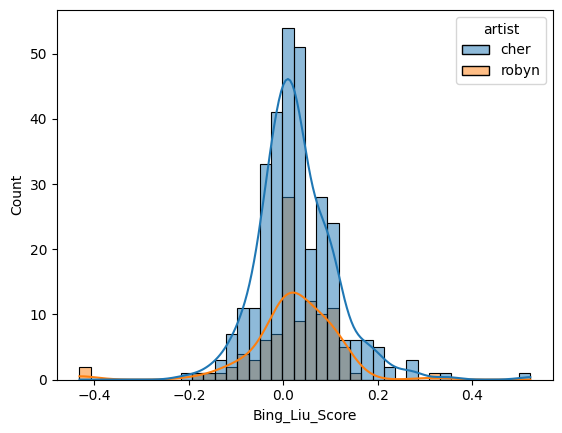

In [34]:
import seaborn as sns
sns.histplot(data=lyrics_data, x='Bing_Liu_Score', hue= 'artist', kde=True)

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [37]:
positive_emojis = ['😀', '😃', '😁', '😂', '🤣', '😉', '😍', '😇', '🥰', '😘', '😋', '😜', '🙂', '😆', '😚']
negative_emojis = ['🤨','😞', '😟', '🙃', '😫', '🥺', '😢', '😭', '😤', '😠', '😡', '🤬', '🥵', '😥', '👿']


emoji_sentiment = dict(zip(positive_emojis, [1]*15))
emoji_sentiment.update(dict(zip(negative_emojis,[-1]*15)))

TypeError: 'dict' object is not callable

In [36]:
emoji_sentiment

NameError: name 'emoji_sentiment' is not defined

In [33]:
def get_desc_sentiment(desc, sent= emoji_sentiment):
    sentiment = sum([sent[ch] for ch in str(desc) if ch in sent]):
    return(sentiment)

def extract_emojis(desc, emoji_list):
    emojis = [ch in ch in str(desc) if ch in emoji_list]:
    return(emojis)


SyntaxError: expected ':' (3255622621.py, line 1)

In [ ]:
twitter_data.description.apply(get_desc_sentiment)
twitter_data['pos_emoji']=twitter_data.description.apply(extract_emojis)
twitter_data['neg_emoji']=twitter_data.description.apply(extract_emojis)

In [ ]:
twitter_data.query('sentiment > 0').head()

In [ ]:
twitter_data.query('sentiment < 0').head()

In [ ]:
twitter_data.groupby('artist').sentiment.mean()

Q: What is the average sentiment of your two artists? 

A: <!-- Your answer here --> 

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: <!-- Your answer here --> 

